In [3]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss
import sdeint
import sympy as smp
from sympy import real_roots

## Generate figures for the thesis

### Figure 1 - Hopf System Noiseless
Purpose -> to illustrate the evolution of the Hopf system's dynamics in feature space as a function of control parameter $\mu$ in the trivial case where noise is set to 0 and length is set to 5000.

In [4]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = 1 # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evaluate(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['eta'] = test_samples['eta'].values
        self.testDataNorm['mu'] = test_samples['mu'].values
        self.testDataNorm['model'] = test_samples['model'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def predict(self, proj_samples, proj_ts, showPlot=False): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        # project new data into calibrated space
        #predicted_proba = list()
        abc = RadiusNeighborsClassifier(radius=self.epsilon, outlier_label='most_frequent')
        abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
        y_pred = abc.predict_proba(self.projDataNorm.iloc[:,:22])

        if showPlot:
            fig = plt.figure(figsize=(8,5))
            plt.ylabel('P(M|D)', fontsize=15)
            plt.xlabel('Model', fontsize=15)
            models = abc.classes_
            plt.title(f"True = {proj_samples['model'].values[0]}, Predicted = {abc.predict(self.projDataNorm.iloc[:,:22])[0]}, $\epsilon = {self.epsilon}$", fontsize=15)
            sns.barplot(x=models, y=y_pred[0])
            plt.show()
        
        return [y_pred, abc.predict(self.projDataNorm.iloc[:,:22]), abc.classes_]


    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated

    def getDistances(self):
        features = self.calDataNorm.iloc[:, 0:22]
        classes = self.calDataNorm['model']

        # Split the dataset into different classes
        class_data = defaultdict(list)
        for idx, row in df.iterrows():
            class_data[row['model']].append(row[:22].values)

        # Calculate pairwise distances within each class
        intra_class_distances = {}
        for class_label, feature_vectors in class_data.items():
            intra_class_distances[class_label] = pairwise_distances(feature_vectors)

        # Calculate pairwise distances between different classes
        inter_class_distances = defaultdict(dict)
        for class_label_1, feature_vectors_1 in class_data.items():
            for class_label_2, feature_vectors_2 in class_data.items():
                if class_label_1 != class_label_2:
                    inter_class_distances[class_label_1][class_label_2] = pairwise_distances(feature_vectors_1, feature_vectors_2)

        return intra_class_distances, inter_class_distances
        
    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon

In [385]:
def gen_hopf(mu, eta, num_samples, N): # num samples
    # hopf
    eta_val_hopf = np.tile(eta, num_samples)
    mu_val_hopf = np.tile(mu, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N+500)*dt
    lengths = list()
    tspan = np.arange(0, length, dt)
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
        #sols_list.append(sol)
        #lengths.append(len(sol[500:]))
        lengths.append(len(sol[500:]))
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['mu'] = mu_val_hopf
    df_hopf['N'] = lengths
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'HopfLC'
    return ts_hopf, df_hopf

In [323]:
mu = -1
eta = 0
ts_hopf_single, df_hopf_single = gen_hopf(mu, eta, 1, 5000)


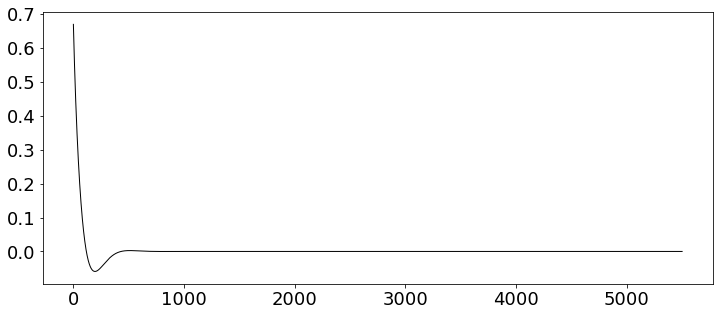

In [325]:
plt.figure(figsize=(12,5))
plt.plot(ts_hopf_single[0, :], c='k', linewidth=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('hopf_determ_N1.png', dpi=350)

## generate hopf bifurcation diagram noiseless case

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def hopf_system(state, t, mu, eta):
    x, y = state
    dxdt = mu * x - y - x * (x**2 + y**2)
    dydt = x + mu * y - y * (x**2 + y**2)
    return [dxdt, dydt]

def generate_hopf_bifurcation(mu_values, eta, initial_state, timesteps):
    points = []

    for mu in mu_values:
        sol = odeint(hopf_system, initial_state, timesteps, args=(mu, eta))
        x = sol[:, 0]

        # Discard initial transient points
        x = x[-len(x)//2:]

        points.append((mu, np.min(x)))
        points.append((mu, np.max(x)))

    return points

mu_values = np.linspace(-5, 5, 1000)
eta = 0
initial_state = [1, 1]
timesteps = np.linspace(0, 200, 5000) 

points = generate_hopf_bifurcation(mu_values, eta, initial_state, timesteps)



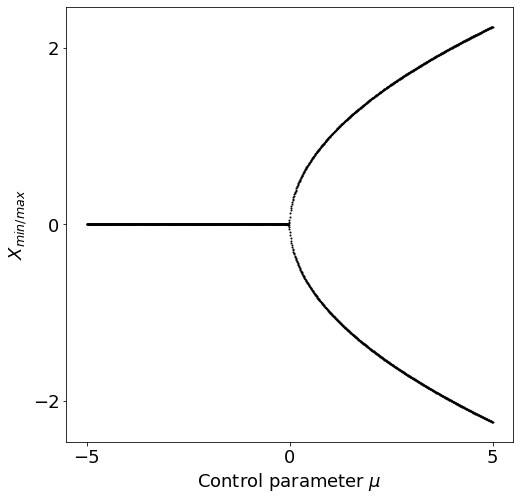

In [224]:
# Plot the bifurcation diagram
mu, x = zip(*points)
plt.figure(figsize=(8, 8))
plt.scatter(mu, x, s=1, c='k')
plt.xlabel('Control parameter $\mu$', fontsize=18)
plt.xticks([-5, 0, 5], fontsize=18)
plt.ylabel('$X_{min/max}$', fontsize=18)
plt.yticks([-2, 0, 2], fontsize=18)
#plt.show()
plt.savefig('hopf_bif_clean.png', dpi=350)



In [318]:
df_hopf_main_stoch.iloc[600]

0          -1.316887
1          -1.146398
2         120.080533
3              318.0
4           1.404597
5               -0.0
6            0.20331
7              450.0
8           0.015283
9              637.0
10          7.834132
11              40.0
12          0.869565
13             -0.06
14          0.008455
15          0.999267
16              18.0
17          1.185248
18          0.734694
19          0.653061
20          0.009971
21          0.042026
mu          1.006006
N               5000
eta              0.2
regime        HopfLC
Name: 0, dtype: object

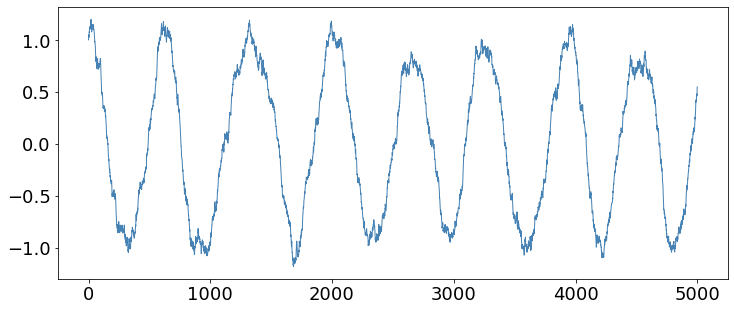

In [319]:
plt.figure(figsize=(12,5))
plt.plot(ts_hopf_main_stoch[600][0,500:], c='steelblue', linewidth=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('hopf_determ_stochP1', dpi=350)

## Noisy Case

In [429]:
mu_values_stoch = np.linspace(-5,5, 1000)
#mus = np.linspace(-1, 1, 20)
eta = 0.5
df_hopf_main_stoch = pd.DataFrame()
ts_hopf_main_stoch = list()
for mu in mu_values:
    ts_hopf, df_hopf = gen_hopf(mu, eta, 1, 5000)
    ts_hopf_main_stoch.append(ts_hopf)
    df_hopf_main_stoch = pd.concat([df_hopf_main_stoch, df_hopf], axis=0)

In [424]:
points_stoch = list()
for index, mu in enumerate(mu_values_stoch):
    points_stoch.append((mu, np.max(ts_hopf_main_stoch[index][0,500:])))
    points_stoch.append((mu, np.min(ts_hopf_main_stoch[index][0,500:])))


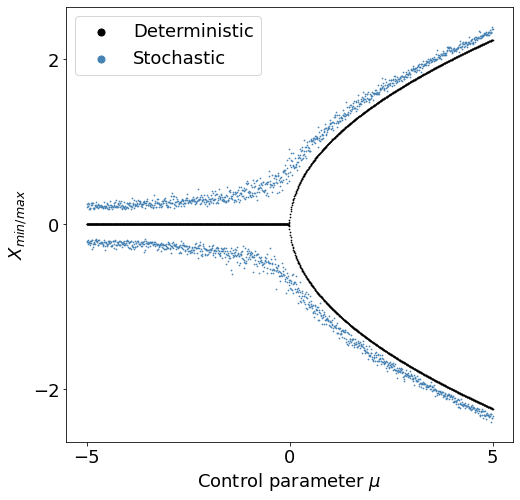

In [388]:
mu2, x2 = zip(*points)
mu1, x1 = zip(*points_stoch)
plt.figure(figsize=(8, 8))
plt.scatter(mu2, x2, s=0.5, c='k', alpha=1, label='Deterministic')
plt.scatter(mu1,x1, s=0.5, c='steelblue', alpha=1, label='Stochastic')
plt.xlabel('Control parameter $\mu$', fontsize=18)
plt.xticks([-5, 0, 5], fontsize=18)
plt.ylabel('$X_{min/max}$', fontsize=18)
plt.yticks([-2, 0, 2], fontsize=18)
plt.legend(fontsize=18, markerscale=10)
#plt.savefig('hopf_bif_stoch_labelled.png', dpi=350)



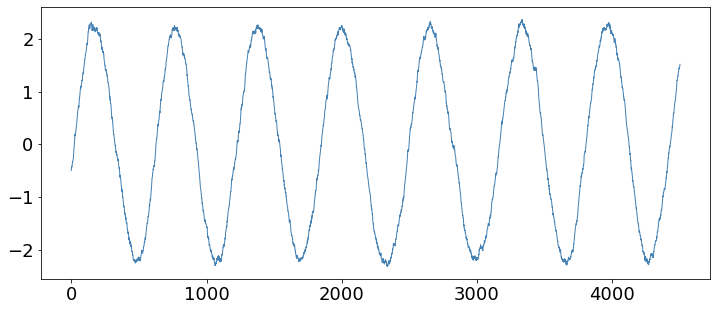

In [389]:
plt.figure(figsize=(12,5))
plt.plot(ts_hopf_main_stoch[999][0,500:], c='steelblue', linewidth=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('hopf_stoch_muP5', dpi=350)

In [174]:
mu = 0.5
eta = 0.6
ts_hopf, df_hopf = gen_hopf(mu, eta, 1, 5000)

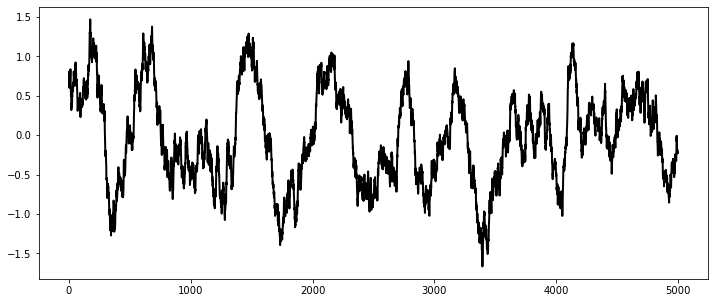

In [177]:
plt.figure(figsize=(12,5))
plt.plot(ts_hopf[0, 500:], c='k', linewidth=2)
plt.savefig('hopf_ts_mu_05_eta_06.png', dpi=350)

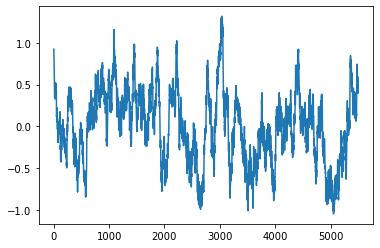

In [173]:
plt.plot(ts_hopf_main[0][0])

In [430]:
rs = RobustScaler().fit(df_hopf_main_stoch.iloc[:,:22])
rs_fit = rs.transform(df_hopf_main_stoch.iloc[:,:22])
#def sigmoid(x, theta):
#        return 1/(1+np.exp(-theta*x))
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [431]:
pca = PCA(n_components=2).fit_transform(X_hat)

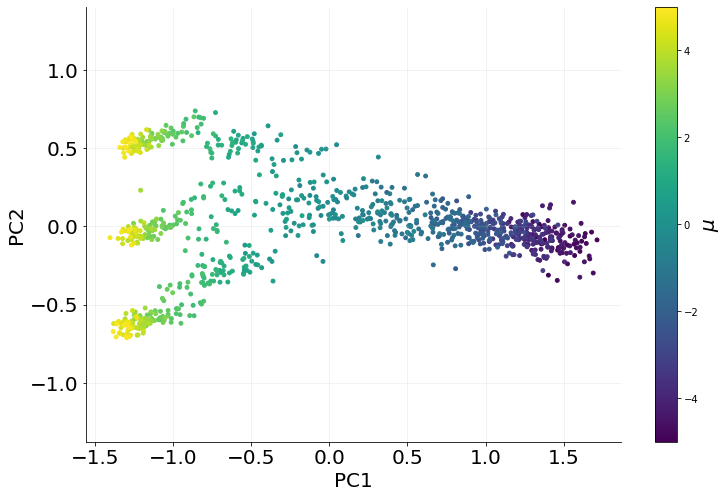

In [432]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hopf_main_stoch['mu'], cmap='viridis', s=15)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)
plt.savefig('hopf_pca_stoch.png', dpi=350)


In [434]:
def gen_hopf2(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
    ic = np.array(np.random.uniform(size=2))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:, 0]

In [435]:
def sample_hopf(num_samples, eta_val=None, n_val=None, mu_val=None, seed=0):
    np.random.seed(seed=seed)
    regime_store = list()
    # hopf system
    if eta_val is not None:
        eta_val_hopf = np.repeat(eta_val, num_samples)
    else:
        eta_val_hopf = np.random.uniform(0.01, 1, num_samples)
    if mu_val is not None:
        mu_val_hopf = np.repeat(mu_val, num_samples)
    else:
        mu_val_hopf = np.random.uniform(-5, 5, num_samples)
    if n_val is not None:
        N_val_hopf = np.repeat(n_val, num_samples)
    else:
        N_val_hopf = np.random.uniform(50, 5000, num_samples)
    lengths_store = list()
    sols_list = list()
    for i in range(num_samples):
        # check regime
        if mu_val_hopf[i] > 0:
            regime_store.append('LimitCycle')
        else:
            regime_store.append('FixedPoint')
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        N = N_val_hopf[i]
        sol = gen_hopf2(eta, mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)

    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    ts = sols_list # return list of 2 dim. time series
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths_store
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['system'] = 'Hopf'
    df['regime'] = regime_store

    return ts, df

In [436]:
ts, df = sample_hopf(1000, eta_val=0.6, n_val=5000)

In [438]:
rs = RobustScaler().fit(df.iloc[:,:22])
rs_transformed = rs.transform(df.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed

In [439]:
pca = PCA(n_components=2).fit(xhat)
embedding = pca.transform(xhat)

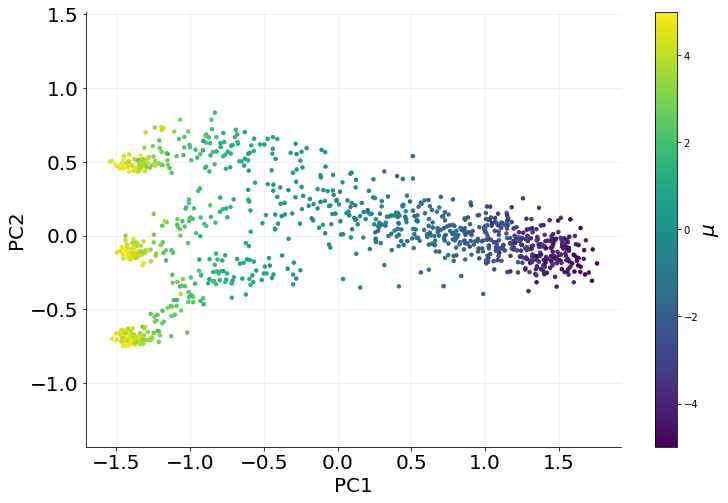

In [443]:
plt.figure(figsize=(12,8))
plt.scatter(embedding[:,0], embedding[:,1], c=df['mu'], cmap='viridis', s=12)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

In [444]:
ts2, df2 = sample_hopf(1000, eta_val=0.6, n_val=100)

In [445]:
rs = RobustScaler().fit(df2.iloc[:,:22])
rs_transformed = rs.transform(df2.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
embedding = pca.transform(xhat)

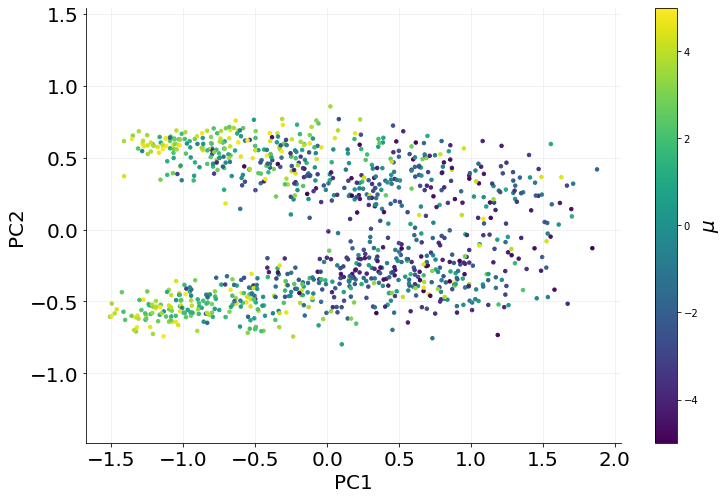

In [448]:
plt.figure(figsize=(12,8))
plt.scatter(embedding[:,0], embedding[:,1], c=df2['mu'], cmap='viridis', s=12)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

In [418]:
mu_values_clean = np.linspace(-5,5, 1000)
#mus = np.linspace(-1, 1, 20)
eta = 0
df_hopf_main_clean = pd.DataFrame()
ts_hopf_main_clean = list()
for mu in mu_values:
    ts_hopf, df_hopf = gen_hopf(mu, eta, 1, 5000)
    ts_hopf_main_clean.append(ts_hopf)
    df_hopf_main_clean = pd.concat([df_hopf_main_clean, df_hopf], axis=0)

In [419]:
len(ts_hopf_main_clean[0][0])

5000

In [420]:
rs = RobustScaler().fit(df_hopf_main_clean.iloc[:,:22])
rs_fit = rs.transform(df_hopf_main_clean.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [421]:
pca = PCA(n_components=2).fit_transform(X_hat)

In [376]:
len(ts_hopf_main_clean)

1000

replot corresponding bifurcation diagram

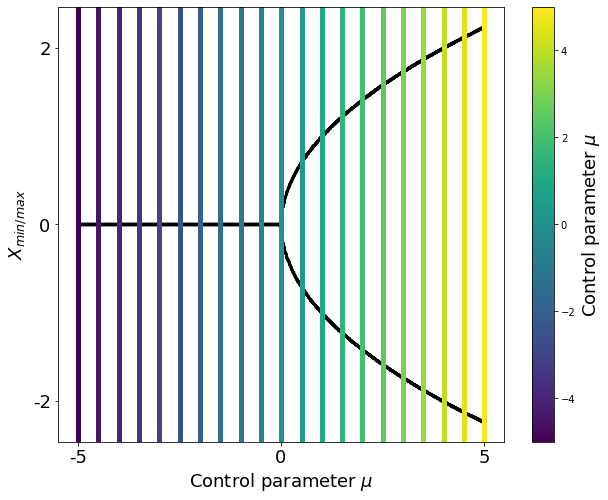

In [368]:
import matplotlib.cm as cm
import numpy as np

mu2, x2 = zip(*points)

# Create a colormap
cmap = cm.get_cmap('viridis')  # Choose the colormap here
norm = plt.Normalize(min(mu2), max(mu2))

fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(mu2, x2, s=5, c='k', alpha=1)

# Only draw a line for every 100th value of mu2
for i, mu in enumerate(mu2):
    if (i % 100 == 0) or (mu==5):  # Only proceed if i is a multiple of 100
        color = cmap(norm(mu))
        ax.axvline(x=mu, color=color, lw=5)


ax.set_xlabel('Control parameter $\mu$', fontsize=18)
ax.set_xticks([-5, 0, 5])
ax.set_xticklabels([-5, 0, 5], fontsize=18)

ax.set_ylabel('$X_{min/max}$', fontsize=18)
ax.set_yticks([-2, 0, 2])
ax.set_yticklabels([-2, 0, 2], fontsize=18)


# Add colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Control parameter $\mu$', fontsize=18)
plt.savefig('sampling_bifurcation.png', dpi=350)

#plt.show()

### Figure 2 - Hopf System Noisy

In [13]:
pca = PCA(n_components=2).fit_transform(X_hat)

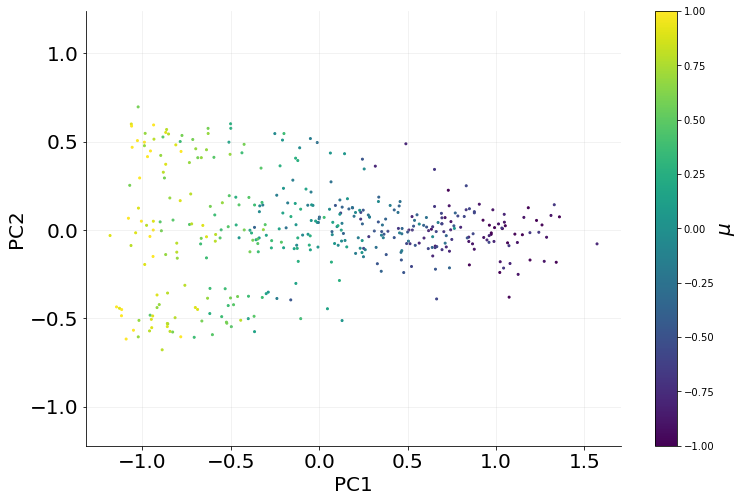

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hopf_main['mu'], cmap='viridis', s=4)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

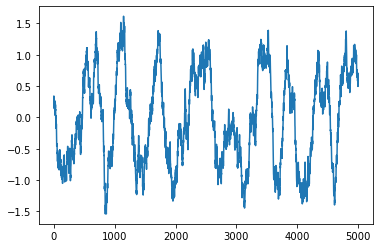

In [21]:
plt.plot(ts_hopf[0])

In [259]:
Ns = [50, 100, 200, 500, 1000, 2000, 5000]
df_hopf_main = pd.DataFrame()
ts_hopf_main = np.array([])
for N in Ns:
    ts_hopf, df_hopf = gen_hopf(-1, 0.1, 20, N)
    df_hopf_main = pd.concat([df_hopf_main, df_hopf], axis=0)

In [260]:
rs = RobustScaler().fit(df_hopf_main.iloc[:,:22])
rs_fit = rs.transform(df_hopf_main.iloc[:,:22])
#def sigmoid(x, theta):
#        return 1/(1+np.exp(-theta*x))
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)
pca = PCA(n_components=2).fit_transform(X_hat)

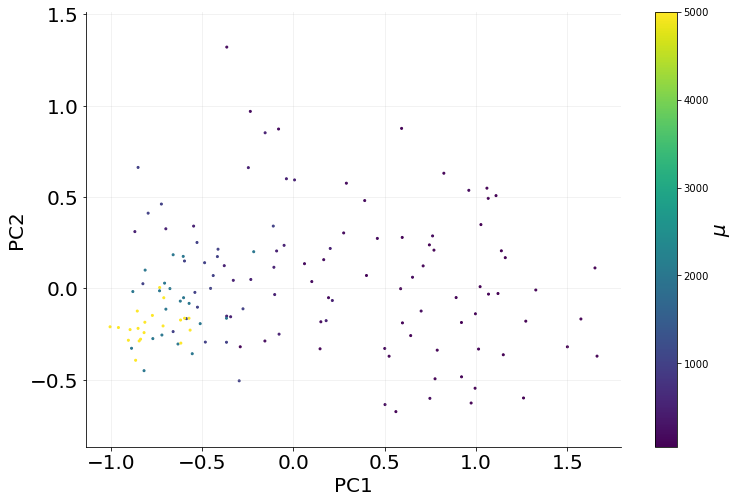

In [261]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hopf_main['N'], cmap='viridis', s=4)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

---------

# Figure 3 - Bistable system low noise

In [160]:
def gen_bistable(num_samples, eta, mu, N):
    eta_val_bistable = np.tile(eta, num_samples)
    mu_val_bistable = np.tile(mu, num_samples)
    n_val_bistable = np.tile(N, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N+500)*dt
    tspan = np.arange(0, length, dt)
    regime = list()
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            regime.append('Switching')
            # add switching label
        else:
            regime.append('Fixed Point')
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['N'] = n_val_bistable
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = regime
    return ts_bistable, df

Switching illustration for noise-driven dynamics

In [246]:
ts_no_noise, _ = gen_bistable(1, 0, 0, 5000)
ts_noise1, _ = gen_bistable(1, 0.2, 0, 5000)
ts_noise2, _ = gen_bistable(1, 0.5, 0, 5000)
ts_noise3, _ = gen_bistable(1, 1, 0, 5000)

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 11 Text major ticklabel objects>)

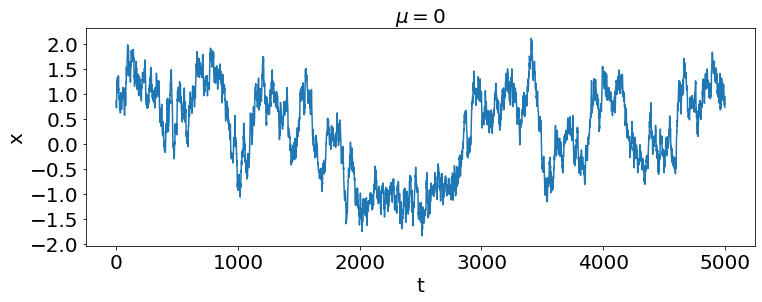

In [247]:
plt.figure(figsize=(12,4))
plt.plot(ts_noise3[0])
plt.title('$\mu = 0$', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

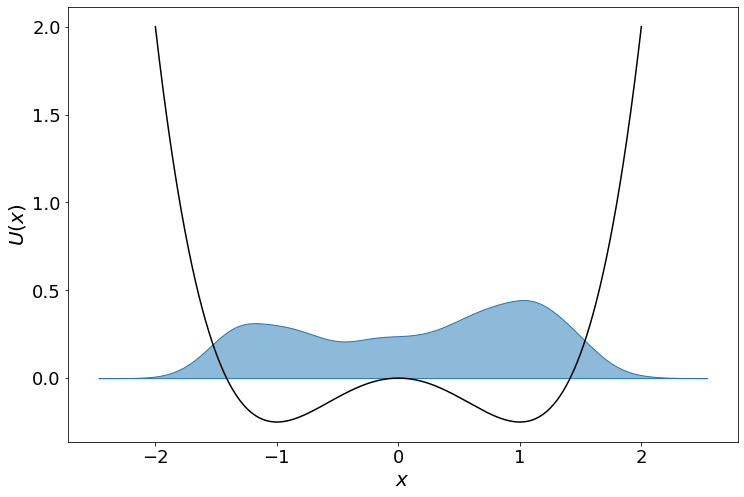

In [224]:
# plot potential energy landscape (quartic potential)
plt.figure(figsize=(12,8))
x = np.linspace(-2, 2, 1000)
def func(x):
    return (1/4)* x**4 - (1/2) * x**2
plt.plot(x, func(x), color='black')
sns.kdeplot(x=ts_noise3[0,:], fill=True, alpha=.5, common_norm=False) #make into kde 
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$U(x)$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [204]:
mus = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
eta = 0.6
df_bs_main = pd.DataFrame()
ts_bs_main = list()
for mu in mus:
    ts_bs, df_bs = gen_bistable(100, eta, mu, 5000)
    df_bs_main = pd.concat([df_bs_main, df_bs], axis=0, ignore_index=True)
    ts_bs_main.append(ts_bs)


In [151]:
rs = RobustScaler().fit(df_bs_main.iloc[:,:22])
rs_fit = rs.transform(df_bs_main.iloc[:,:22])
#def sigmoid(x, theta):
#        return 1/(1+np.exp(-theta*x))
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [152]:
pca = PCA(n_components=2).fit_transform(X_hat)

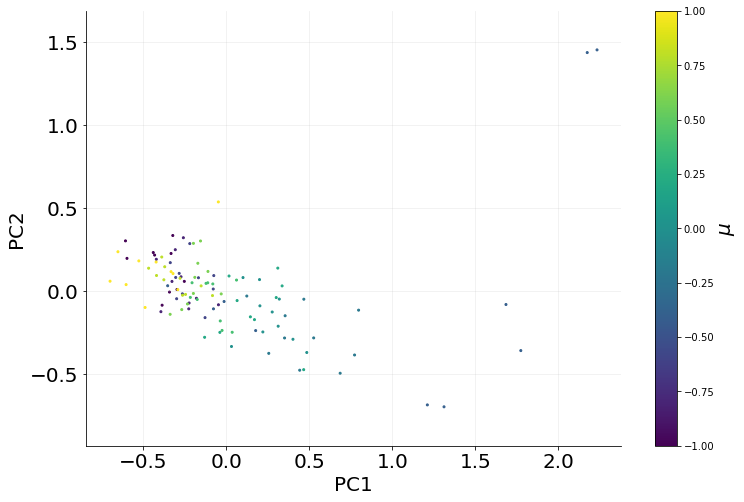

In [153]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_bs_main['mu'], cmap='viridis', s=4)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

# Figure 3 - Bistable system high noise

In [135]:
mus = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
eta = 0.0
df_bs_main = pd.DataFrame()
for mu in mus:
    ts_bs, df_bs = gen_bistable(10, eta, mu, 5000)
    df_bs_main = pd.concat([df_bs_main, df_bs], axis=0, ignore_index=True)

In [143]:
rs = RobustScaler().fit(df_bs_main.iloc[:,:22])
rs_fit = rs.transform(df_bs_main.iloc[:,:22])
#def sigmoid(x, theta):
#        return 1/(1+np.exp(-theta*x))
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

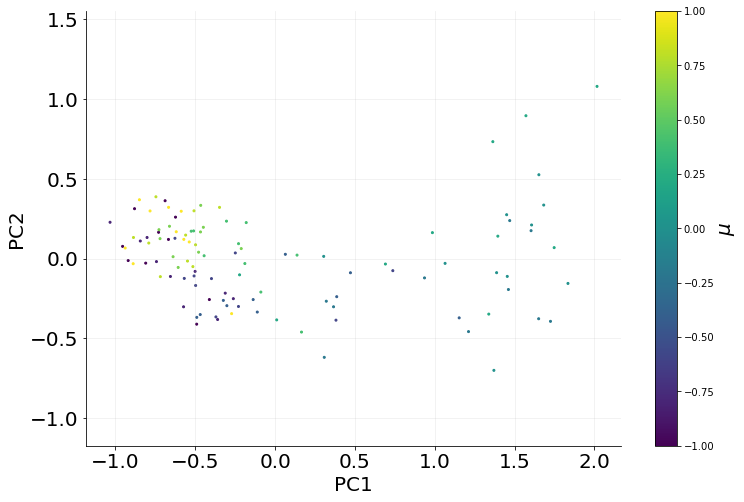

In [144]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_bs_main['mu'], cmap='viridis', s=4)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

In [4]:
# basic unoptimised space

In [82]:
def gen_limitCycle(num_samples): # num samples
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Limit Cycle Instances...')
    for i in range(num_samples):
        if i%100 == 0:
            print(f'{i}/{num_samples}')
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['model'] = 'Limit Cycle'
    return ts_hopf, df

In [83]:
ts_hopflc, df_hopflc = gen_limitCycle(2000)

Generating Limit Cycle Instances...
0/2000
100/2000
200/2000
300/2000
400/2000
500/2000
600/2000
700/2000
800/2000
900/2000
1000/2000
1100/2000
1200/2000
1300/2000
1400/2000
1500/2000
1600/2000
1700/2000
1800/2000
1900/2000


In [85]:
ts_fixedpt, df_fixedpt = gen_fixedpoint(1000)

Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...


In [158]:
def gen_switching(num_samples): # num samples 
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
            mu = np.random.uniform(-0.384, 0.384)
            eta = np.random.uniform(0.2, 1)
            def f(state, t):
                x = state
                dxdt = mu + x - x**3
                return dxdt
            ic = np.array([np.random.uniform()])
            gw = lambda y, t: eta * np.identity(ic.shape[0])
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            X = smp.Symbol('x', real=True)
            eq = mu + X - X**3
            roots = [j.n(6) for j in real_roots(eq, X)]
            max_root = np.max(roots)
            min_root = np.min(roots)
            max_actual = np.max(sol[500:])
            min_actual = np.min(sol[500:])
            # check for switching condition
            if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
                print('switch')
                sols_list.append(sol[500:])
                eta_val_bistable.append(eta)
                mu_val_bistable.append(mu)
                sols_list.append(sol[500:])
                count += 1
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['model'] = 'Bistable Switching'
    return ts_bistable, df

In [159]:
ts_switching, df_switching = gen_switching(10)

switch
switch
switch
switch
switch
switch
switch
switch
switch
switch


ValueError: Length of values (10) does not match length of index (20)

In [157]:
plt.plot(ts_switching[0])

NameError: name 'ts_switching' is not defined